In [1]:
import sys, os
import re

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from scipy import stats
import datetime

import pyodbc
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
import CommonLearningMethods as clm
#---------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
import Utilities_dt
import Plot_Box_sns
import GrubbsTest

Here is the mini-drill too:
1.	Pull the voltage interval data from the last week (10/3 – 10/10) for all meters connected to the transformer numbers 1842743703178 and 1848771706723. You’ll have to join the meter_premise and the reading_ivl_nonvee tables in Hadoop
2.	Plot the voltage data over the week for these meters. Let’s do two different graphs; one for each transformer and their respective meters

Small note: to view the voltage out of the interval data, you’ll have to put aep_derived_uom = 'VOLT' in your WHERE statement


# NOTES

useage_date in usage_nonvee.reading_ivl_nonvee can be used for date instead of grabbing from e.g. starttimeperiod
<br> Try to complete data prep and cleaning in SQL instead of Python

In [2]:
run_local_data = False

In [3]:
cols_of_interest = [
    'mfr_devc_ser_nbr',
    'mtr_stat_cd_desc',
    'first_in_srvc_dt',
    'phys_inst_dt',
    'inst_tod_cd',
    'inst_ts',
    'last_fld_test_date',
    'longitude',
    'latitude',
    'state_cd', 
    'prem_nb',
    'prem_stat_cd',
    'frst_turn_on_dt',
    'hsng_ctgy_cd',
    'srvc_pole_nb',
    'trsf_pole_nb',
    'curr_bill_acct_id',
    'curr_bill_acct_nb',
    'annual_kwh',
    'annual_max_dmnd',
    'latitude_nb',
    'longitude_nb',
    'station_nb', 
    'xfmr_nb'
]

# Setup df_met_prem

In [4]:
if not run_local_data:
    conn = Utilities.get_athena_prod_aws_connection()
    #--------------------------------------------------------
    sql = ("Select {} from default.meter_premise \
           WHERE trsf_pole_nb = '1842743703178' \
           OR trsf_pole_nb = '1848771706723'").format(','.join(cols_of_interest))
    #--------------------------------------------------------
    df_met_prem = pd.read_sql(sql, conn)
    
    #df_met_prem.to_csv(os.path.join(Utilities.get_local_data_dir(), r'mini_drill_from_liam_met_prem.csv'), index=False)

In [5]:
if run_local_data:
    df_met_prem = pd.read_csv(os.path.join(Utilities.get_local_data_dir(), r'mini_drill_from_liam_met_prem.csv'))

In [6]:
print(f'df_met_prem.shape = {df_met_prem.shape}')

df_met_prem.shape = (32, 24)


In [7]:
# common_col_name = 'meter_premise.'
# cols_rename_dict = {x:x[len(common_col_name):] if x.find(common_col_name)>-1 else x 
#                     for x in df_met_prem.columns}
# df_met_prem = df_met_prem.rename(columns=cols_rename_dict)

df_met_prem = clm.remove_longest_substring_shared_by_all_columns_in_df(df_met_prem)

In [8]:
# print(df_met_prem.columns)
# print(df_met_prem.head())

# Setup df_usage

In [9]:
meter_ids = df_met_prem['mfr_devc_ser_nbr'].unique().tolist()
meter_ids = [str(x) for x in meter_ids]
opco_ids = df_met_prem['state_cd'].unique().tolist()
opco_ids = [x.lower() for x in opco_ids]

In [10]:
cols_of_interest = ['serialnumber', 'starttimeperiod', 'endtimeperiod', 'aep_endtime_utc', 
                    'timezoneoffset', 'aep_srvc_qlty_idntfr', 'value']

In [11]:
if not run_local_data:
    # sql = ("Select {} \
    #        from usage_nonvee.reading_ivl_nonvee \
    #        where aep_opco = 'oh' \
    #        and serialnumber IN ({}) \
    #        and aep_usage_dt = '2021-10-12' \
    #        and aep_derived_uom = 'VOLT'").format(','.join(cols_of_interest), 
    #                                              ','.join(meter_ids))


    sql = ("Select {} \
           from usage_nonvee.reading_ivl_nonvee \
           where aep_opco IN ({}) \
           and serialnumber IN ({}) \
           and aep_usage_dt >= '2021-10-03' \
           and aep_usage_dt <= '2021-10-10' \
           and aep_derived_uom = 'VOLT'").format(','.join(cols_of_interest), 
                                                 ','.join(["'{}'".format(x) for x in opco_ids]), 
                                                 ','.join(meter_ids))

    #print(sql)
    df_usage = pd.read_sql(sql, conn)
    
    #df_usage.to_csv(os.path.join(Utilities.get_local_data_dir(), r'mini_drill_from_liam_usage.csv'), index=False)

In [12]:
if run_local_data:
    df_usage = pd.read_csv(os.path.join(Utilities.get_local_data_dir(), r'mini_drill_from_liam_usage.csv'))

In [13]:
print(f'df_usage.shape = {df_usage.shape}')

df_usage.shape = (24576, 7)


In [14]:
# common_col_name = 'reading_ivl_nonvee.'
# cols_rename_dict = {x:x[len(common_col_name):] if x.find(common_col_name)>-1 else x 
#                     for x in df_usage.columns}
# df_usage = df_usage.rename(columns=cols_rename_dict)

df_usage = clm.remove_longest_substring_shared_by_all_columns_in_df(df_usage)

In [15]:
# print(df_usage.columns)
# print(df_usage.head())

# No need to join df_met_prem and df_usage,
since I built that latter using meter_ids from the former.  However, for practice, let's merge them

In [16]:
cols_to_keep_from_met_prem = ['mfr_devc_ser_nbr', 'longitude', 'latitude', 'state_cd', 
                              'srvc_pole_nb', 'trsf_pole_nb', 'station_nb']
df_met_prem[cols_to_keep_from_met_prem].head()

,mfr_devc_ser_nbr,longitude,latitude,state_cd,srvc_pole_nb,trsf_pole_nb,station_nb
0,880325446,-83.0608,39.9294867,OH,1842743703178,1842743703178,0075
1,880704624,-83.06055900,39.929480000,OH,1842743703178,1842743703178,0075
2,880704625,-83.06055900,39.929480000,OH,1842743703178,1842743703178,0075
3,880704634,-83.06055900,39.929480000,OH,1842743703178,1842743703178,0075
4,880704635,-83.06055900,39.929480000,OH,1842743703178,1842743703178,0075


In [17]:
print(df_usage.head())

  serialnumber            starttimeperiod              endtimeperiod  \
0    880325446  2021-10-03T03:00:00-04:00  2021-10-03T03:15:00-04:00   
1    880704624  2021-10-03T19:00:00-04:00  2021-10-03T19:15:00-04:00   
2    880704624  2021-10-03T23:15:00-04:00  2021-10-03T23:30:00-04:00   
3    880705148  2021-10-03T21:30:00-04:00  2021-10-03T21:45:00-04:00   
4    880708159  2021-10-03T13:45:00-04:00  2021-10-03T14:00:00-04:00   

  aep_endtime_utc timezoneoffset aep_srvc_qlty_idntfr       value  
0      1633245300         -04:00                  AVG  244.399994  
1      1633302900         -04:00                  AVG  243.399994  
2      1633318200         -04:00                  AVG  244.199997  
3      1633311900         -04:00                  AVG  245.300003  
4      1633284000         -04:00                  AVG  244.100006  


In [18]:
assert(len(df_met_prem['mfr_devc_ser_nbr'].unique()) == len(df_usage['serialnumber'].unique()))

In [19]:
df_usage = df_usage.merge(df_met_prem[cols_to_keep_from_met_prem], 
                          left_on='serialnumber', right_on='mfr_devc_ser_nbr', 
                          suffixes=('_usage', '_met_prem'))

In [20]:
df_usage['trsf_pole_nb'].unique()

array(['1842743703178', '1848771706723'], dtype=object)

In [21]:
df_usage['starttimeperiod'] = df_usage['starttimeperiod'].apply(lambda x: Utilities_dt.clean_timeperiod_entry(x))
df_usage['endtimeperiod'] = df_usage['endtimeperiod'].apply(lambda x: Utilities_dt.clean_timeperiod_entry(x))

### Use starttimeperiod to determine day
There are cases where df_usage.iloc[i]['starttimeperiod'].date() != df_usage.iloc[i]['endtimeperiod'].date().
<br>I believe this mismatch occurs only for the 11:45pm to 12:00am measurement.
<br>e.g. df_usage.iloc[i]['starttimeperiod'] = 2021-10-03 23:45:00
<br> &emsp;&ensp;&nbsp; df_usage.iloc[i]['endtimeperiod'] = 2021-10-04 00:00:00


In [22]:
df_usage['date'] = pd.to_datetime(df_usage['starttimeperiod']).dt.date

In [23]:
df_usage = df_usage.sort_values(by=['serialnumber', 'date'])

In [24]:
df_usage.head()

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,aep_srvc_qlty_idntfr,value,mfr_devc_ser_nbr,longitude,latitude,state_cd,srvc_pole_nb,trsf_pole_nb,station_nb,date
0,880325446,2021-10-03 03:00:00,2021-10-03 03:15:00,1633245300,-04:00,AVG,244.399994,880325446,-83.0608,39.9294867,OH,1842743703178,1842743703178,0075,2021-10-03
1,880325446,2021-10-03 22:00:00,2021-10-03 22:15:00,1633313700,-04:00,AVG,243.100006,880325446,-83.0608,39.9294867,OH,1842743703178,1842743703178,0075,2021-10-03
2,880325446,2021-10-03 04:15:00,2021-10-03 04:30:00,1633249800,-04:00,AVG,244.699997,880325446,-83.0608,39.9294867,OH,1842743703178,1842743703178,0075,2021-10-03
3,880325446,2021-10-03 10:00:00,2021-10-03 10:15:00,1633270500,-04:00,AVG,241.899994,880325446,-83.0608,39.9294867,OH,1842743703178,1842743703178,0075,2021-10-03
4,880325446,2021-10-03 17:30:00,2021-10-03 17:45:00,1633297500,-04:00,AVG,243.300003,880325446,-83.0608,39.9294867,OH,1842743703178,1842743703178,0075,2021-10-03


# Plotting and whatnot

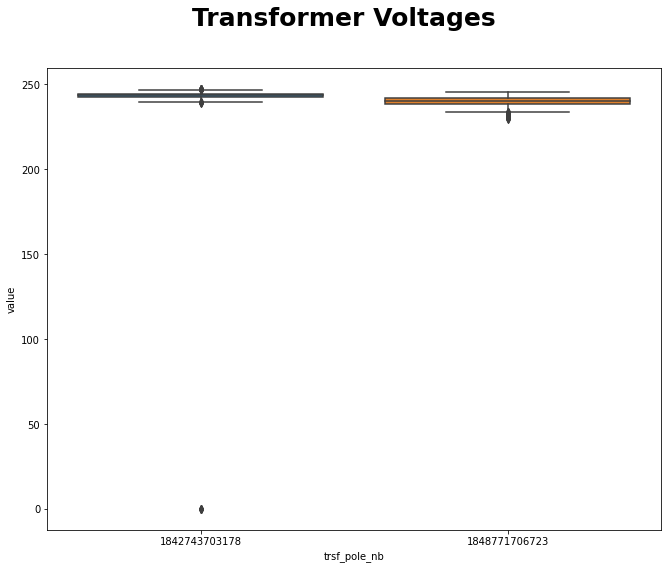

In [25]:
fig_num=0

fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.boxplot(ax=ax, x='trsf_pole_nb', y='value', data=df_usage)
fig.suptitle('Transformer Voltages', fontsize=25, fontweight='bold')
fig_num +=1

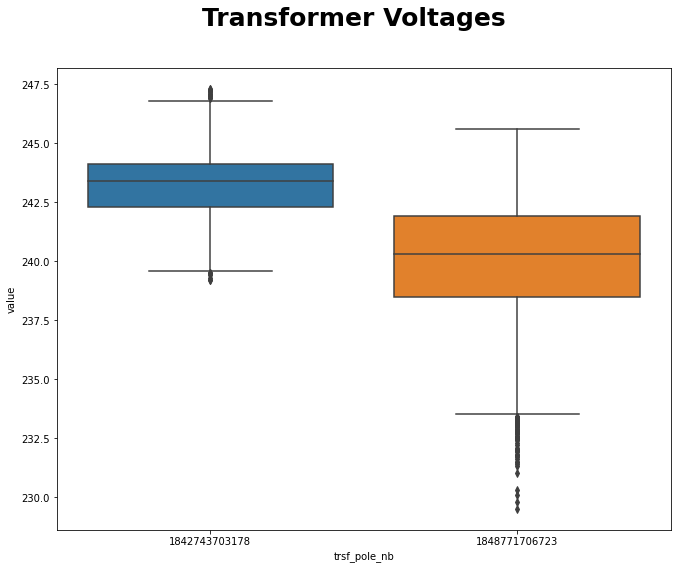

In [26]:
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.boxplot(ax=ax, x='trsf_pole_nb', y='value', data=df_usage[df_usage['value']>0.0])
fig.suptitle('Transformer Voltages', fontsize=25, fontweight='bold')
fig_num +=1

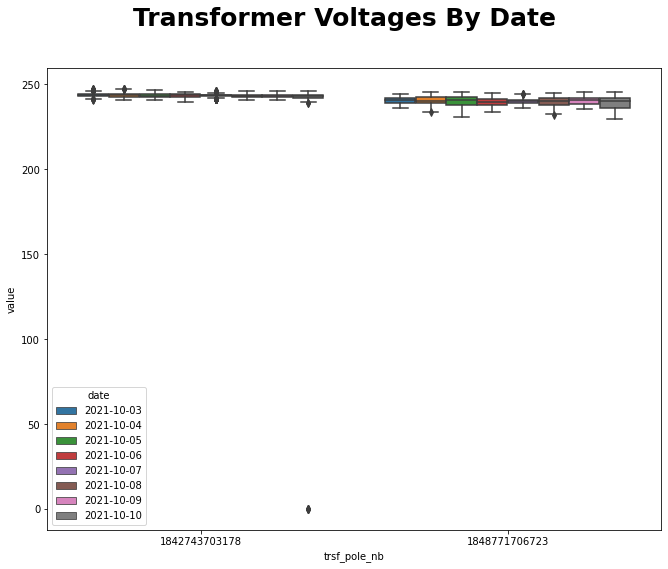

In [27]:
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.boxplot(ax=ax, x='trsf_pole_nb', y='value', hue='date', data=df_usage)
fig.suptitle('Transformer Voltages By Date', fontsize=25, fontweight='bold')
fig_num +=1

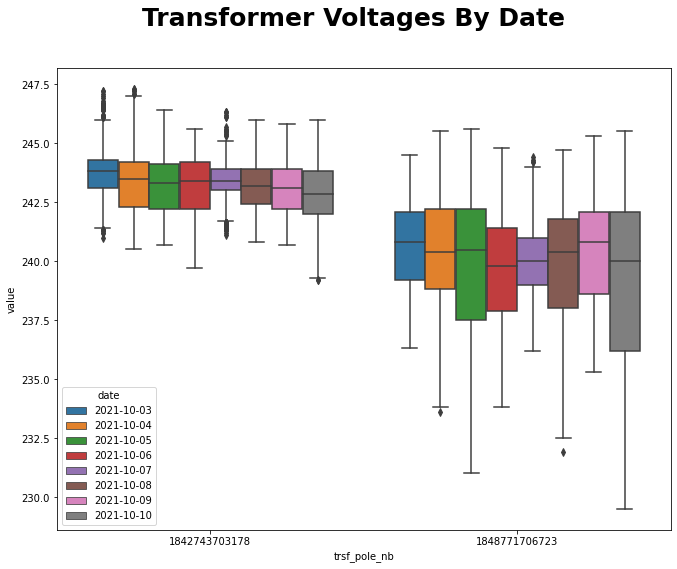

In [28]:
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.boxplot(ax=ax, x='trsf_pole_nb', y='value', hue='date', data=df_usage[df_usage['value']>0.0])
fig.suptitle('Transformer Voltages By Date', fontsize=25, fontweight='bold')
fig_num +=1

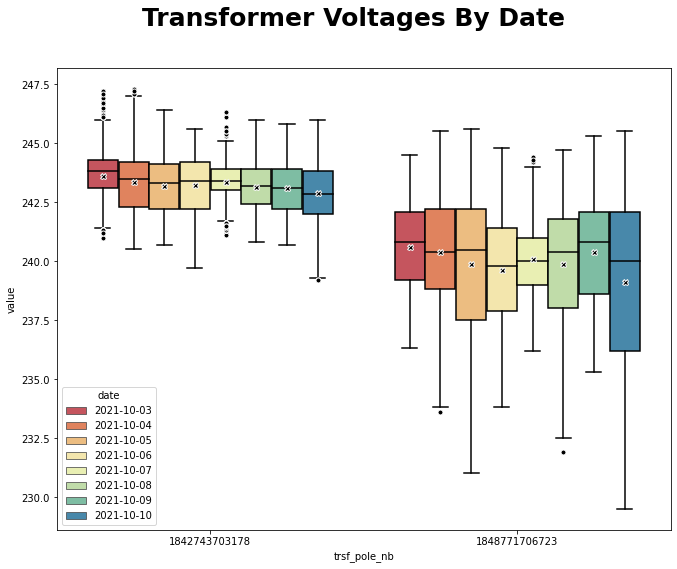

In [29]:
fig, ax = Plot_Box_sns.build_df_box_plot_sns(fig_num, x_group_col='trsf_pole_nb', y_metric_col='value', df=df_usage[df_usage['value']>0.0], hue='date')
fig.suptitle('Transformer Voltages By Date', fontsize=25, fontweight='bold')
fig_num+=1

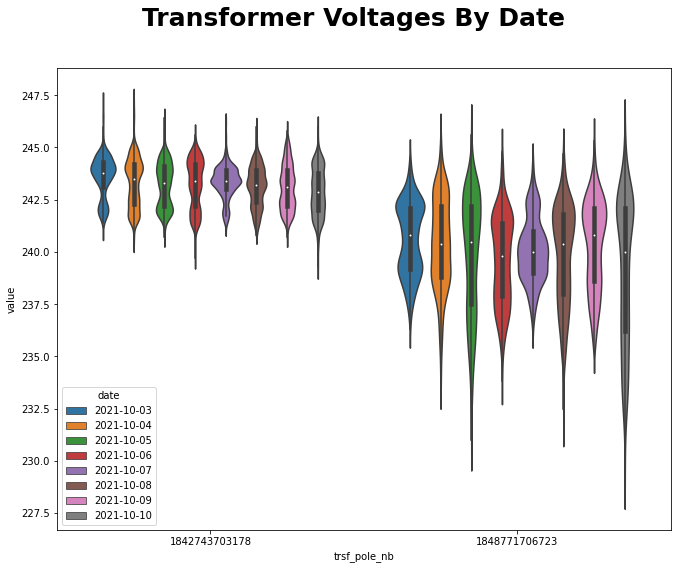

In [30]:
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
fig.suptitle('Transformer Voltages By Date', fontsize=25, fontweight='bold')
sns.violinplot(ax=ax, x='trsf_pole_nb', y='value', hue='date', data=df_usage[df_usage['value']>0.0])
fig_num +=1

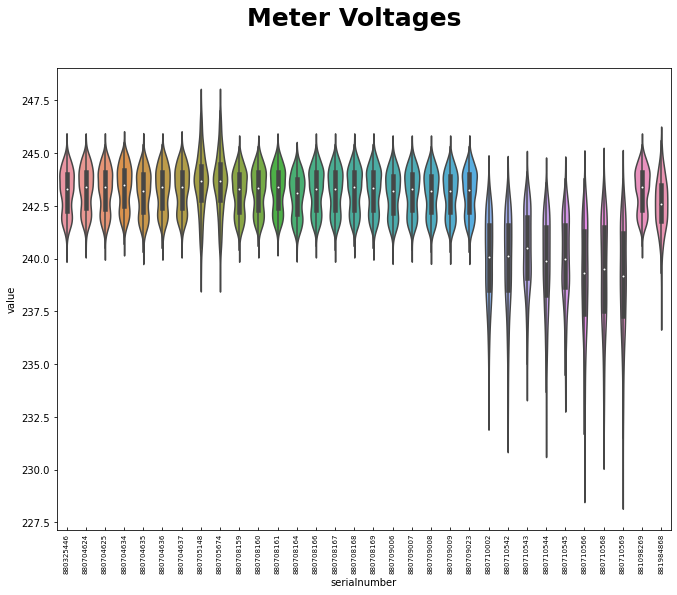

In [31]:
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.violinplot(ax=ax, x='serialnumber', y='value', data=df_usage[df_usage['value']>0.0])
fig.suptitle('Meter Voltages', fontsize=25, fontweight='bold')
ax.tick_params(axis='x', labelrotation=90, labelsize=7.0, direction='in');
fig_num +=1

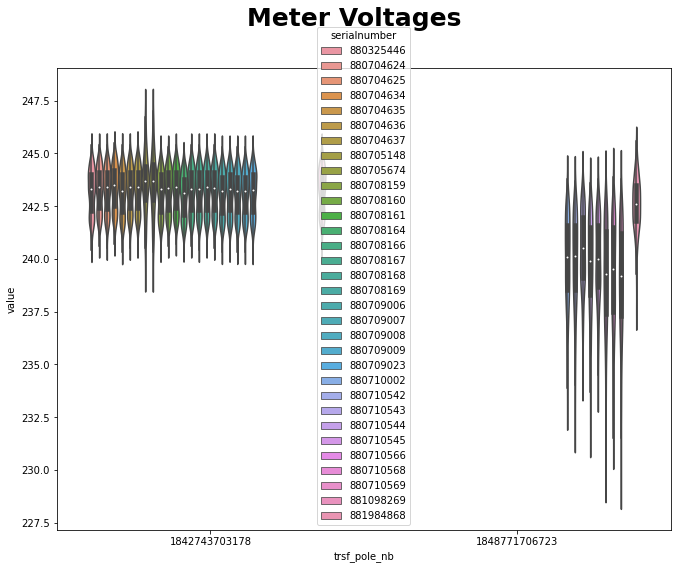

In [32]:
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.violinplot(ax=ax, x='trsf_pole_nb', y='value', hue='serialnumber', data=df_usage[df_usage['value']>0.0])
fig.suptitle('Meter Voltages', fontsize=25, fontweight='bold')
fig_num +=1

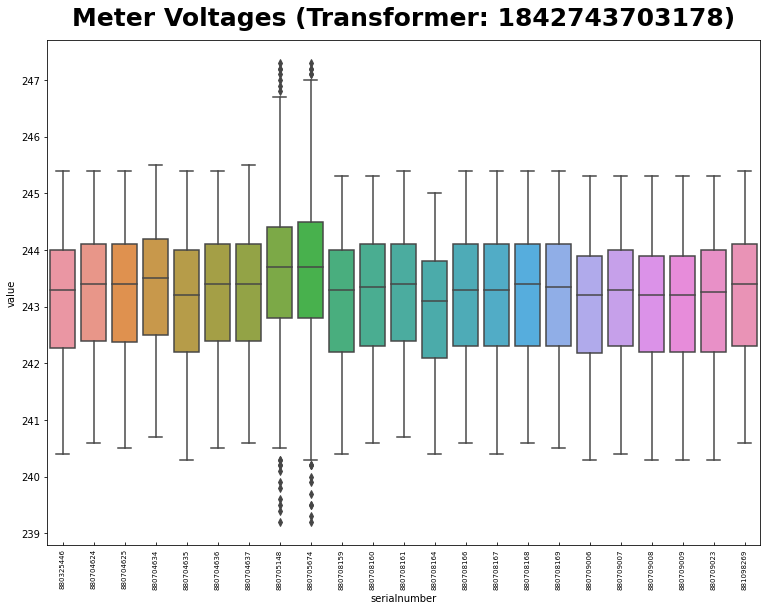

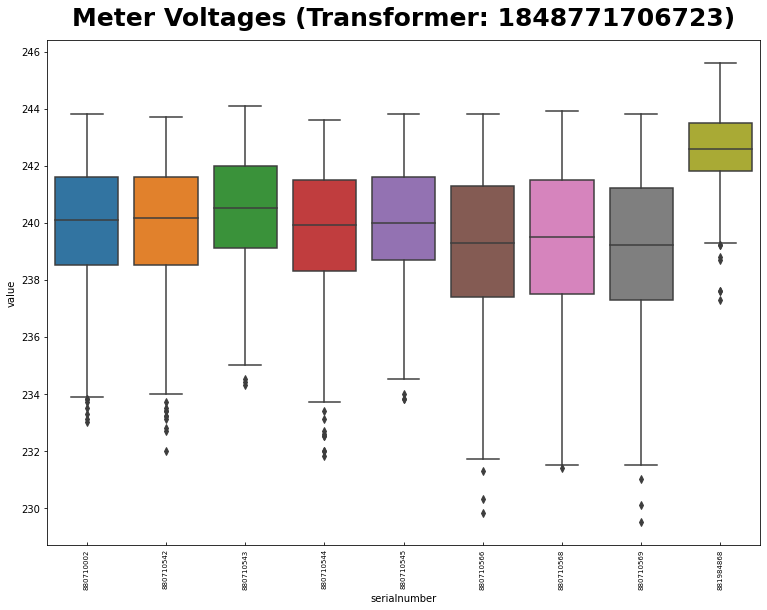

In [33]:
for transformer in df_usage['trsf_pole_nb'].unique():
    tmp_df = df_usage[df_usage['trsf_pole_nb']==transformer]
    fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
    sns.boxplot(ax=ax, x='serialnumber', y='value', data=tmp_df[tmp_df['value']>0.0])
    ax.tick_params(axis='x', labelrotation=90, labelsize=7.0, direction='in');
    plt.subplots_adjust(top=0.925, bottom=0.10, left=0.050, right=0.95)
    fig.suptitle(f'Meter Voltages (Transformer: {transformer})', fontsize=25, fontweight='bold')
    fig_num +=1

In [34]:
df_usage['serialnumber'].unique()

array(['880325446', '880704624', '880704625', '880704634', '880704635',
       '880704636', '880704637', '880705148', '880705674', '880708159',
       '880708160', '880708161', '880708164', '880708166', '880708167',
       '880708168', '880708169', '880709006', '880709007', '880709008',
       '880709009', '880709023', '880710002', '880710542', '880710543',
       '880710544', '880710545', '880710566', '880710568', '880710569',
       '881098269', '881984868'], dtype=object)

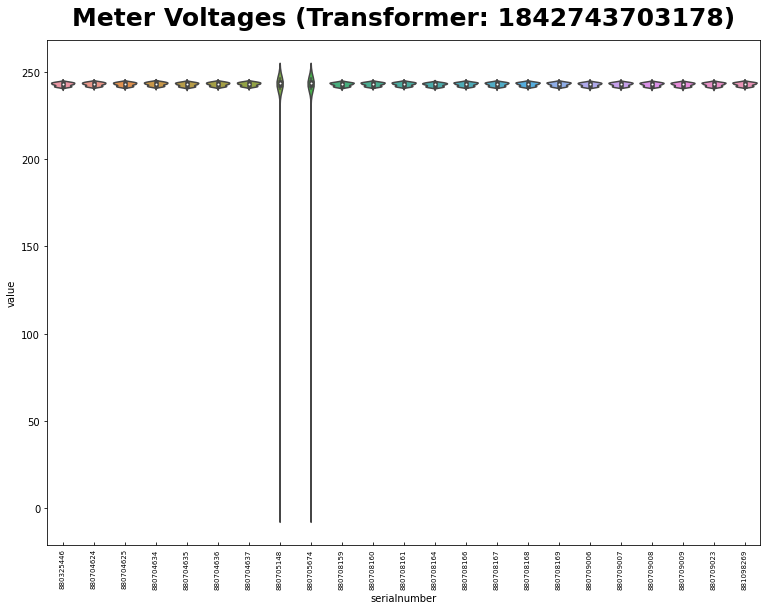

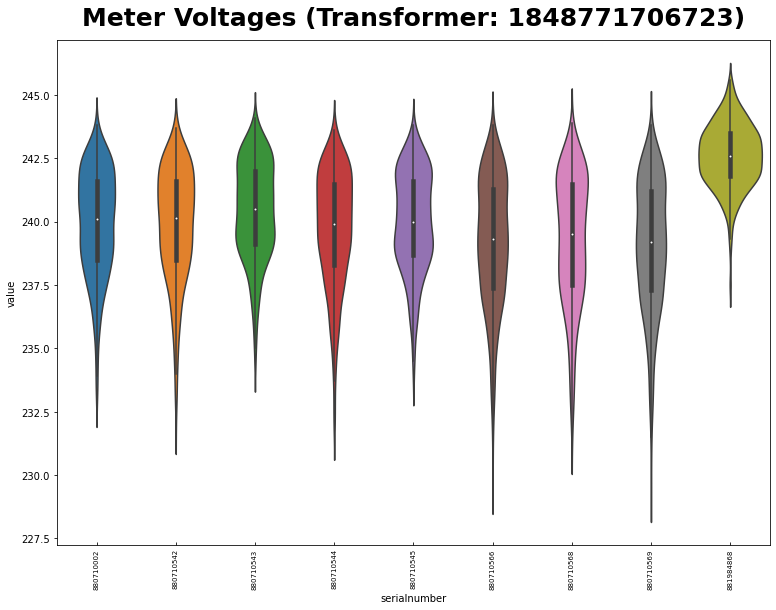

In [35]:
for transformer in df_usage['trsf_pole_nb'].unique():
    tmp_df = df_usage[df_usage['trsf_pole_nb']==transformer]
    fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
    sns.violinplot(ax=ax, x='serialnumber', y='value', data=tmp_df)
    ax.tick_params(axis='x', labelrotation=90, labelsize=7.0, direction='in');
    plt.subplots_adjust(top=0.925, bottom=0.10, left=0.050, right=0.95)
    fig.suptitle(f'Meter Voltages (Transformer: {transformer})', fontsize=25, fontweight='bold')
    fig_num +=1

In [36]:
plot_all_meters = False
if plot_all_meters:
    for meter in df_usage['serialnumber'].unique():
        tmp_df = df_usage[df_usage['serialnumber']==meter]
        transformer = tmp_df['trsf_pole_nb'].unique().tolist()
        assert(len(transformer)==1)
        transformer = transformer[0]

        fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
        sns.violinplot(ax=ax, x='date', y='value', data=tmp_df[tmp_df['value']>0.0])
        ax.tick_params(axis='x', labelrotation=45, labelsize=7.0, direction='in');
        plt.subplots_adjust(top=0.925, bottom=0.10, left=0.050, right=0.95)
        fig.suptitle(f'Meter: {meter} (Transformer: {transformer})', fontsize=25, fontweight='bold')
        fig_num +=1

In [37]:
plot_all_meters = False
if plot_all_meters:
    for meter in df_usage['serialnumber'].unique():
        tmp_df = df_usage[df_usage['serialnumber']==meter]
        transformer = tmp_df['trsf_pole_nb'].unique().tolist()
        assert(len(transformer)==1)
        transformer = transformer[0]

        fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
        sns.boxplot(ax=ax, x='date', y='value', data=tmp_df[tmp_df['value']>0.0])
        ax.tick_params(axis='x', labelrotation=45, labelsize=7.0, direction='in');
        plt.subplots_adjust(top=0.925, bottom=0.10, left=0.050, right=0.95)
        fig.suptitle(f'Meter: {meter} (Transformer: {transformer})', fontsize=25, fontweight='bold')
        fig_num +=1

# Play around with broken axis

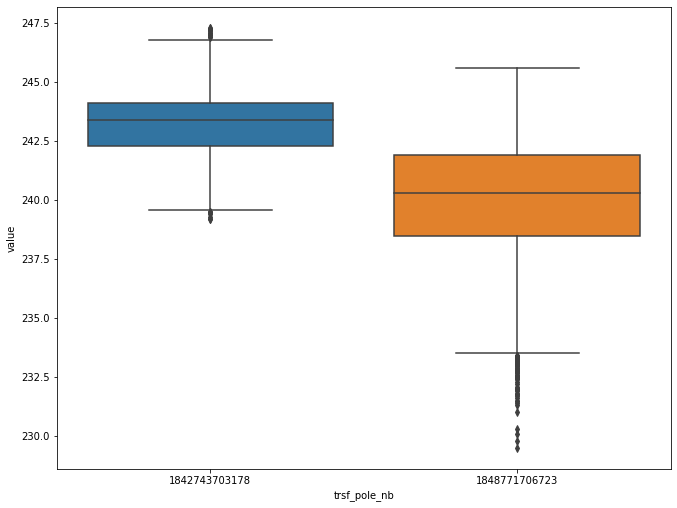

In [38]:
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.boxplot(ax=ax, x='trsf_pole_nb', y='value', data=df_usage[df_usage['value']>0])
fig_num +=1

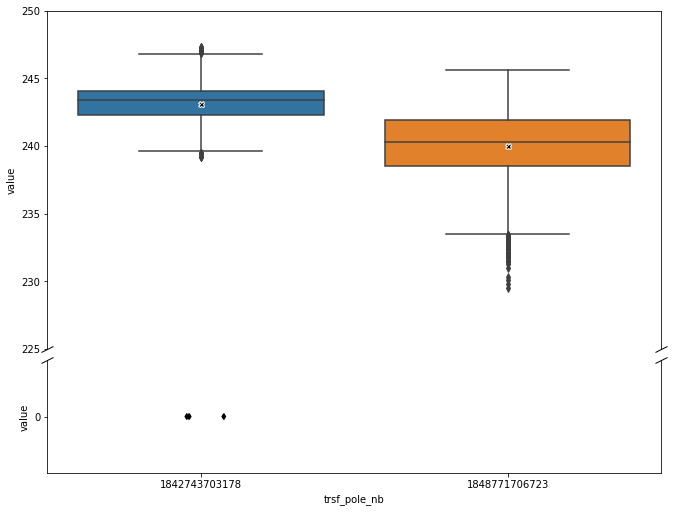

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, num=fig_num, figsize=[11, 8.5], 
                               sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

meanprops = {'color':'black', 'marker':'X', 'markerfacecolor':'black', 'markeredgecolor':'white'}

sns.boxplot(ax=ax1, x='trsf_pole_nb', y='value', data=df_usage, showmeans=True, meanprops=meanprops)
#sns.boxplot(ax=ax2, x='trsf_pole_nb', y='value', data=df_usage, showmeans=True)
sns.stripplot(ax=ax2, x='trsf_pole_nb', y='value', data=df_usage, marker='d', color='black')

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(225, 250)  # outliers only
ax2.set_ylim(-0.01, 0.01)  # most of the data

# Turn off labels on x-axis of ax1
ax1.xaxis.set_visible(False)

# Only single tick for bottom y-axis at 0
ax2.set_yticks([0])

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

fig_num +=1

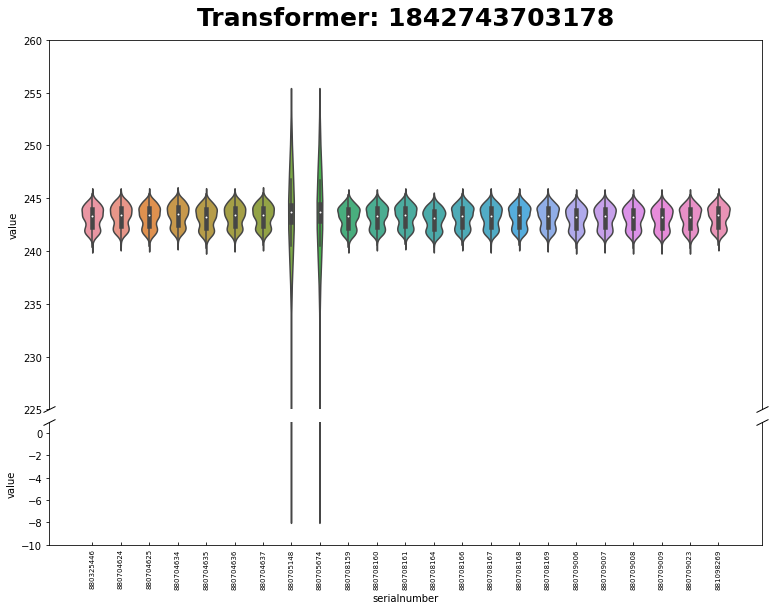

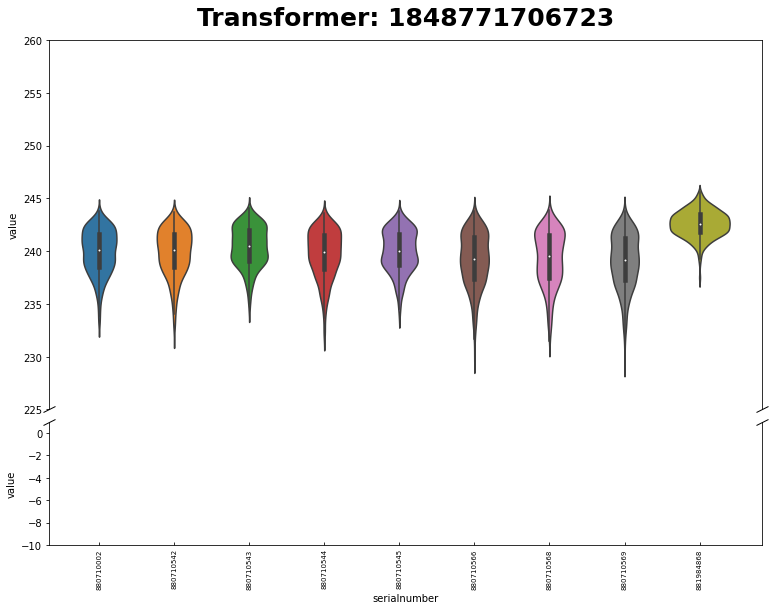

In [40]:
for transformer in df_usage['trsf_pole_nb'].unique():
    tmp_df = df_usage[df_usage['trsf_pole_nb']==transformer]
    fig, (ax1, ax2) = plt.subplots(2, 1, num=fig_num, figsize=[11, 8.5], 
                                   sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    fig.subplots_adjust(hspace=0.05)  # adjust space between axes
    
    sns.violinplot(ax=ax1, x='serialnumber', y='value', data=tmp_df)
    sns.violinplot(ax=ax2, x='serialnumber', y='value', data=tmp_df)
    
    # zoom-in / limit the view to different portions of the data
    ax1.set_ylim(225, 260)  # outliers only
    ax2.set_ylim(-10, 1)  # most of the data

    # Turn off labels on x-axis of ax1
    ax1.xaxis.set_visible(False)

    # Only single tick for bottom y-axis at 0
    #ax2.set_yticks([0])
    
    # hide the spines between ax and ax2
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    # Now, let's turn towards the cut-out slanted lines.
    # We create line objects in axes coordinates, in which (0,0), (0,1),
    # (1,0), and (1,1) are the four corners of the axes.
    # The slanted lines themselves are markers at those locations, such that the
    # lines keep their angle and position, independent of the axes size or scale
    # Finally, we need to disable clipping.

    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
    
    ax2.tick_params(axis='x', labelrotation=90, labelsize=7.0, direction='in');
    plt.subplots_adjust(top=0.925, bottom=0.10, left=0.050, right=0.95)
    fig.suptitle(f'Transformer: {transformer}', fontsize=25, fontweight='bold')
    fig_num +=1

# Line Plots

In [41]:
transformers = df_usage['trsf_pole_nb'].unique().tolist()

In [42]:
transformers

['1842743703178', '1848771706723']

In [43]:
tmp_df = df_usage[df_usage['trsf_pole_nb']==transformers[0]].copy()

In [44]:
tmp_df['serialnumber']=tmp_df['serialnumber'].astype(str)

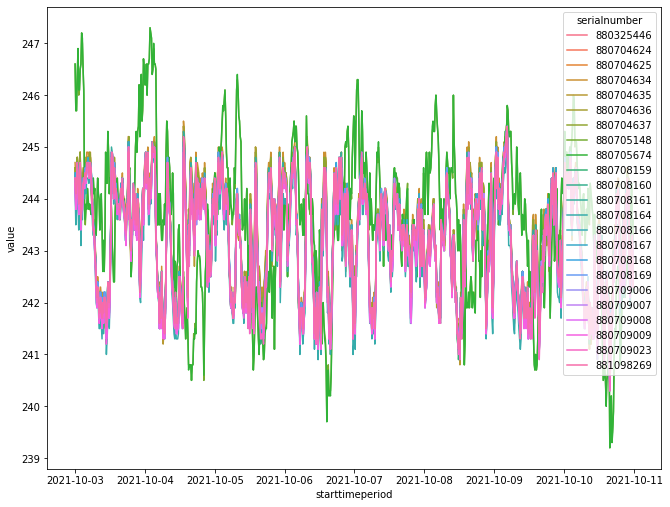

In [45]:
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.lineplot(ax=ax, x='starttimeperiod', y='value', hue='serialnumber', data=tmp_df[tmp_df['value']>0])
fig_num +=1

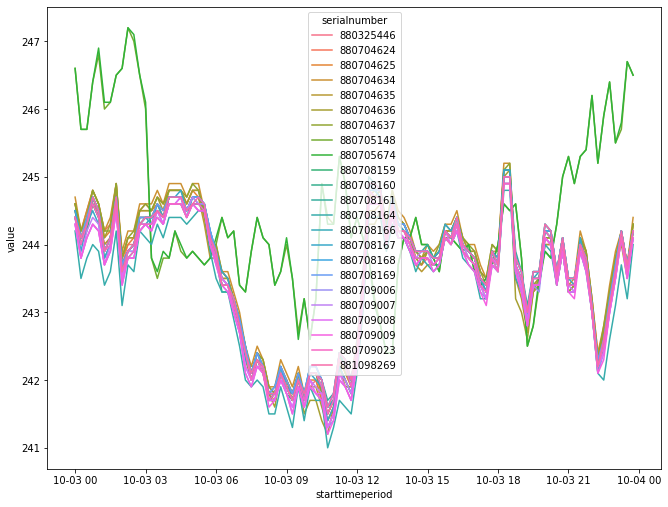

In [46]:
tmp_date = tmp_df['date'].unique()[0]
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.lineplot(ax=ax, x='starttimeperiod', y='value', hue='serialnumber', data=tmp_df[(tmp_df['value']>0) & (tmp_df['date']==tmp_date)])
fig_num +=1

In [47]:
data1 = tmp_df[tmp_df['serialnumber']=='880325446'].copy()
data2 = tmp_df[tmp_df['serialnumber']=='880704624'].copy()

In [48]:
dist = np.linalg.norm(data1['value'].subtract(data2['value'], fill_value=0))

In [49]:
dist

9532.790045626929

In [50]:
dist2 = np.linalg.norm(data1.set_index('starttimeperiod')['value']-data2.set_index('starttimeperiod')['value'])

In [51]:
dist2

4.086551404145207

In [52]:
data1['value'].subtract(data2['value'], fill_value=0)

0       244.399994
1       243.100006
2       244.699997
3       241.899994
4       243.300003
           ...    
1531   -242.399994
1532   -242.000000
1533   -243.500000
1534   -243.000000
1535   -243.399994
Name: value, Length: 1536, dtype: float64

In [53]:
data1.set_index('starttimeperiod')['value']-data2.set_index('starttimeperiod')['value']

starttimeperiod
2021-10-03 00:00:00   -0.100006
2021-10-03 00:15:00   -0.099991
2021-10-03 00:30:00   -0.199997
2021-10-03 00:45:00   -0.100006
2021-10-03 01:00:00   -0.200012
                         ...   
2021-10-10 22:45:00   -0.199997
2021-10-10 23:00:00   -0.100006
2021-10-10 23:15:00   -0.099991
2021-10-10 23:30:00   -0.199997
2021-10-10 23:45:00   -0.100006
Freq: 15T, Name: value, Length: 768, dtype: float64

In [54]:
data1.iloc[0]['value']

244.39999389648438

In [55]:
data2.iloc[0]['value']

243.39999389648438

In [56]:
data1.iloc[0]

serialnumber                      880325446
starttimeperiod         2021-10-03 03:00:00
endtimeperiod           2021-10-03 03:15:00
aep_endtime_utc                  1633245300
timezoneoffset                       -04:00
aep_srvc_qlty_idntfr                    AVG
value                            244.399994
mfr_devc_ser_nbr                  880325446
longitude                          -83.0608
latitude                         39.9294867
state_cd                                 OH
srvc_pole_nb                  1842743703178
trsf_pole_nb                  1842743703178
station_nb                             0075
date                             2021-10-03
Name: 0, dtype: object

In [57]:
serial_numbers = tmp_df['serialnumber'].unique().tolist()

In [58]:
diffs = []
for i in range(len(serial_numbers)):
    for j in range(i+1, len(serial_numbers)):
        df_i = tmp_df[tmp_df['serialnumber']==serial_numbers[i]]
        df_j = tmp_df[tmp_df['serialnumber']==serial_numbers[j]]
        #diff = (np.linalg.norm(df_i['value'].subtract(df_j['value'], fill_value=0)))
        diff = np.linalg.norm(df_i.set_index('starttimeperiod')['value']-df_j.set_index('starttimeperiod')['value'])
        diffs.append(diff)

In [59]:
len(diffs)

253

(array([211.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  42.]),
 array([  0.84851699,  42.81769098,  84.78686496, 126.75603895,
        168.72521293, 210.69438692, 252.6635609 , 294.63273489,
        336.60190887, 378.57108286, 420.54025684]),
 <BarContainer object of 10 artists>)

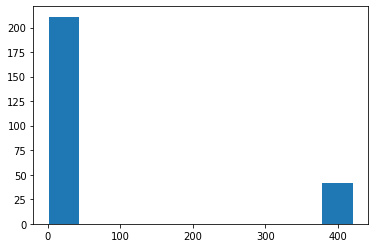

In [60]:
plt.hist(diffs)

In [61]:
np.mean(diffs)

73.55559278863473

In [62]:
np.std(diffs)

154.7301901394302

In [63]:
diffs2 = []
for i in range(len(serial_numbers)):
    df_i = tmp_df[tmp_df['serialnumber']==serial_numbers[i]]
    df_others = tmp_df[tmp_df['serialnumber']!=serial_numbers[i]]
    diff = np.linalg.norm(df_i.set_index('starttimeperiod')['value']-df_others.groupby('starttimeperiod').mean()['value'])
    diffs2.append(diff)

In [64]:
len(diffs2)

23

(array([21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 37.98655856,  74.31140401, 110.63624946, 146.96109491,
        183.28594036, 219.61078581, 255.93563126, 292.26047671,
        328.58532216, 364.91016761, 401.23501305]),
 <BarContainer object of 10 artists>)

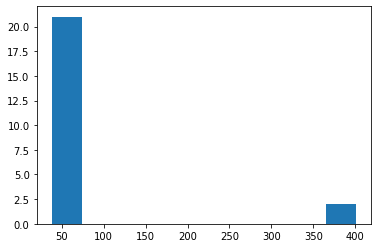

In [65]:
plt.hist(diffs2)

In [66]:
tmp_df['serialnumber'].unique()

array(['880325446', '880704624', '880704625', '880704634', '880704635',
       '880704636', '880704637', '880705148', '880705674', '880708159',
       '880708160', '880708161', '880708164', '880708166', '880708167',
       '880708168', '880708169', '880709006', '880709007', '880709008',
       '880709009', '880709023', '881098269'], dtype=object)

In [67]:
pivot_df = tmp_df.pivot(index='starttimeperiod', columns='serialnumber', values='value').T

In [68]:
pivot_df.columns

DatetimeIndex(['2021-10-03 00:00:00', '2021-10-03 00:15:00',
               '2021-10-03 00:30:00', '2021-10-03 00:45:00',
               '2021-10-03 01:00:00', '2021-10-03 01:15:00',
               '2021-10-03 01:30:00', '2021-10-03 01:45:00',
               '2021-10-03 02:00:00', '2021-10-03 02:15:00',
               ...
               '2021-10-10 21:30:00', '2021-10-10 21:45:00',
               '2021-10-10 22:00:00', '2021-10-10 22:15:00',
               '2021-10-10 22:30:00', '2021-10-10 22:45:00',
               '2021-10-10 23:00:00', '2021-10-10 23:15:00',
               '2021-10-10 23:30:00', '2021-10-10 23:45:00'],
              dtype='datetime64[ns]', name='starttimeperiod', length=768, freq=None)

In [69]:
pivot_df_cpy=pivot_df.copy()

In [70]:
n_outliers = 0.25*len(pivot_df.columns)
pivot_df, (fails_df, output_info_dfs, n_outliers) = GrubbsTest.run_grubbs_with_output_info(pivot_df, n_outliers_to_fail=n_outliers)

In [71]:
fails_df

starttimeperiod,2021-10-03 00:00:00,2021-10-03 00:15:00,2021-10-03 00:30:00,2021-10-03 00:45:00,2021-10-03 01:00:00,2021-10-03 01:15:00,2021-10-03 01:30:00,2021-10-03 01:45:00,2021-10-03 02:00:00,2021-10-03 02:15:00,...,2021-10-10 21:30:00,2021-10-10 21:45:00,2021-10-10 22:00:00,2021-10-10 22:15:00,2021-10-10 22:30:00,2021-10-10 22:45:00,2021-10-10 23:00:00,2021-10-10 23:15:00,2021-10-10 23:30:00,2021-10-10 23:45:00
serialnumber,,,,,,,,,,,,,,,,,,,,,
880705148,246.600006,245.699997,245.699997,246.399994,246.800003,246.000000,246.100006,246.5,246.600006,247.199997,...,242.800003,242.5,242.800003,242.600006,242.699997,243.699997,243.899994,244.199997,243.100006,243.600006
880705674,246.600006,245.699997,245.699997,246.399994,246.899994,246.100006,246.100006,246.5,246.600006,247.199997,...,242.800003,242.5,242.899994,242.600006,242.699997,243.699997,243.899994,244.300003,243.100006,243.600006


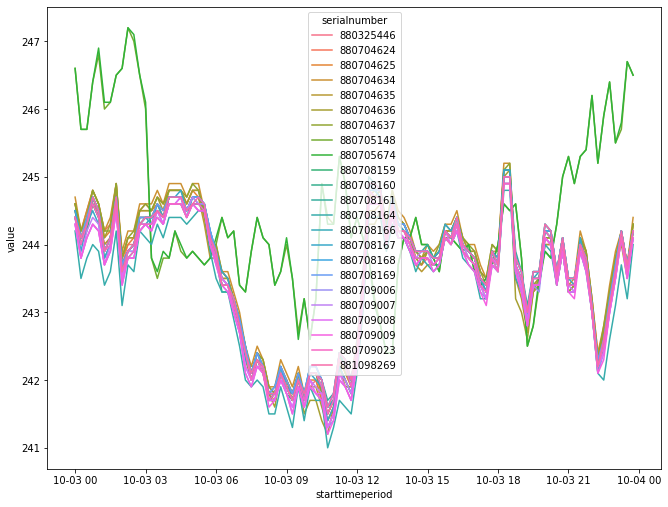

In [72]:
tmp_date = tmp_df['date'].unique()[0]
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.lineplot(ax=ax, x='starttimeperiod', y='value', hue='serialnumber', data=tmp_df[(tmp_df['value']>0) & (tmp_df['date']==tmp_date)])
fig_num +=1

In [73]:
len(pivot_df.columns)

768